# ASTR 596: FDS Homework 6: Hunting for Exoplanets


### If you are watching Star Trek: Picard, then you might wonder about the "Admonition" - a warning/message left in an octuple planet system about past synthetic life in the Galaxy.

### [Ethan Siegel's Starts With a Bang blog has even covered it](https://www.forbes.com/sites/startswithabang/2020/03/19/is-star-trek-picards-hypothesized-octuple-star-system-really-possible/)

### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg">


### But is there a system with 8 planets??? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with `gatspy`. 


### To get the Kepler data, you'll need the `lightkurve` package

> `conda install lightkurve`

### I've included some code to get the light curve, clean it and remove the NaNs, but not outliers (you can judge the wisdom of outlier removal when you are hunting for planets).


<hr>

#### Hints:

* `gatspy` has a `predict` method that you can use to get a model light curve for some period (you should need no more 3-5 terms). You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next.

* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html)

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [68]:
%matplotlib inline
import lightkurve as lk
import gatspy
import numpy as np

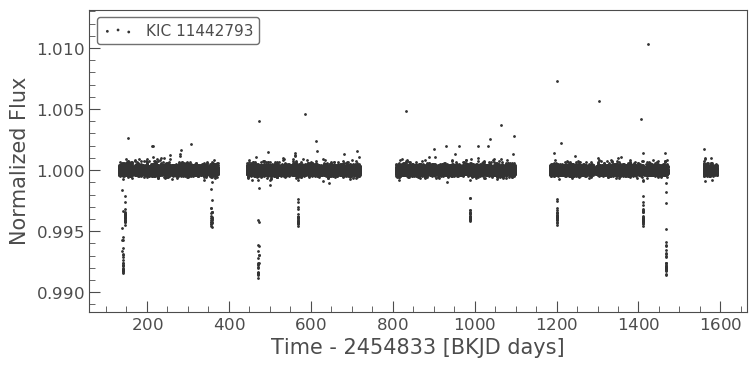

In [101]:
lcfs = lk.search_lightcurvefile('Kepler-90', mission='Kepler').download_all()

def squelch_rednoise(lc):
    corrected_lc = lc.normalize().flatten(window_length=51)
    return corrected_lc

stitched_lc = lcfs.PDCSAP_FLUX.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans()

clc.scatter();

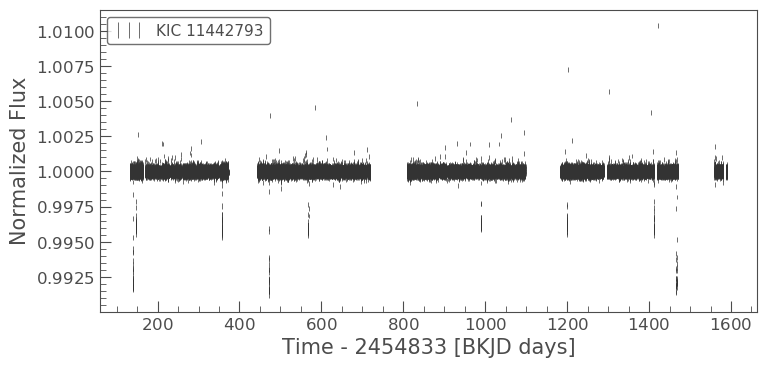

In [102]:
flat, trend = clc.flatten(window_length=301, return_trend=True)
flat.errorbar(label="KIC 11442793")

In [149]:
def create_periodgram(clc, planet_number):
    periodogram = clc.to_periodogram(method="bls", period=np.arange(50, 350, 0.05))
    periodogram.plot()
    best_fit_period = periodogram.period_at_max_power
    print('Best fit period: {:.3f}'.format(best_fit_period))
    ax = clc.fold(period=best_fit_period, t0=periodogram.transit_time_at_max_power).errorbar()
    ax.set_xlim(-0.01,0.01) #zoom into the prominent dip around zero
    ax.set_title("PLANET " + str(planet_number))
    
    return periodogram

def find_all_transits(periodogram, clc):
    best_fit_period = periodogram.period_at_max_power
    time_first_transit = periodogram.transit_time_at_max_power
    time_upper_bound = np.max(clc.time) + 200

    transit_LC = []
    for i in range(5):
        peak = time_first_transit + i*best_fit_period.value
        if peak <= time_upper_bound:
            transit_LC.append(peak)

    return transit_LC

def mask_lc(clc,transit_LC):
    mask = np.ones(len(clc.time))
    for transit in transit_LC:
        index = np.argmin(np.abs(clc.time-transit)) #index of the peak center
        total_points = np.arange(index - 50, index + 50, 1)# 50 points to the left and right of the center of peak
        for point in total_points: # make those points zero
            if point <len(clc.time):
                mask[point] = 0
    mask = mask.astype(bool) # will get rid of planet transit
    #print(mask)    
    new_lc = lk.lightcurve.KeplerLightCurve(clc.time[mask],clc.flux[mask],clc.flux_err[mask])
    return new_lc



Best fit period: 331.600 d


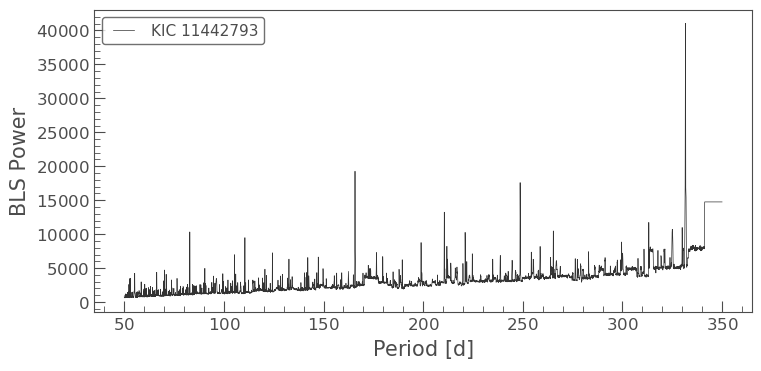

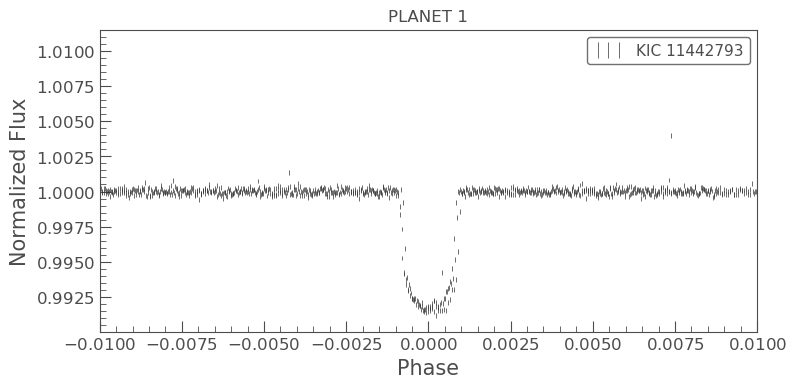

In [150]:
##### PLANET 1 #########
P1_periodogram = create_periodgram(clc, 1)

Best fit period: 210.600 d


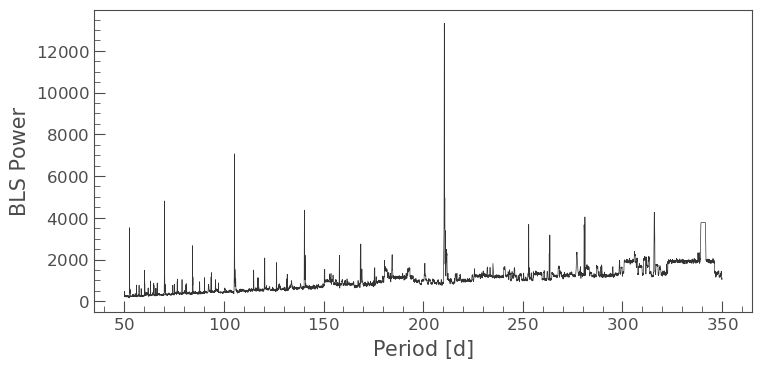

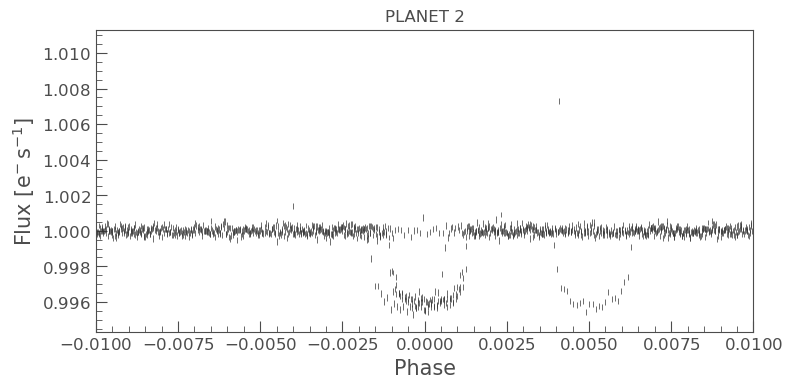

In [151]:
##### PLANET 2 #########
P1_transit_LC = find_all_transits(P1_periodogram, clc)
P2_lc = mask_lc(clc,P1_transit_LC)
P2_periodogram = create_periodgram(P2_lc, 2)



Best fit period: 339.350 d


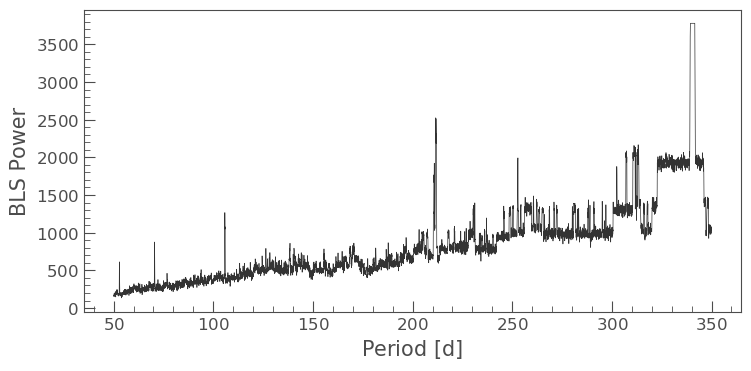

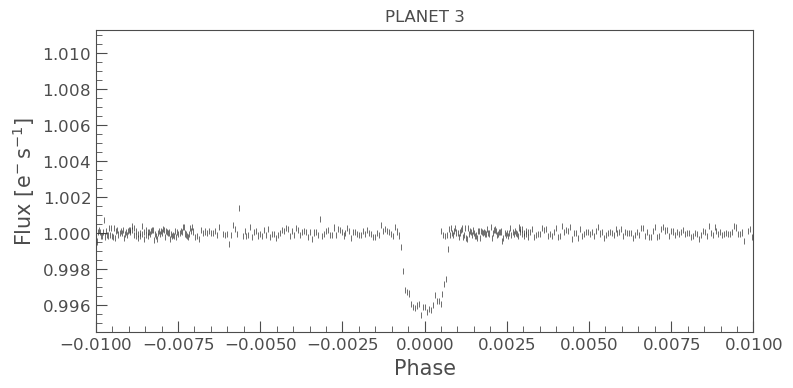

In [153]:
##### PLANET 3 #########
P2_transit_LC = find_all_transits(P2_periodogram, P2_lc)
P3_lc = mask_lc(P2_lc,P2_transit_LC)
P3_periodogram = create_periodgram(P3_lc, 3)

The periods for Planet 1,2 correspond closely to planet h,g. For planet 3, the period that was predicted is larger than the longest period of any planet. But when period of planet 3 is devided by 4, it is closest to planet f. 